In [22]:
!pip install super-gradients
!pip install imutils
!pip install pytube --upgrade

In [23]:
import torch
torch.__version__

'2.1.2'

In [24]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
os.makedirs('/kaggle/working/shoplifting_checkpoints')

In [27]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/kaggle/working/shoplifting_checkpoints'
trainer = Trainer(experiment_name = 'shoplifting_1', ckpt_root_dir= CHECKPOINT_DIR)

# Loading The Data

In [28]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [29]:
dataset_params = {
    'data_dir':'/kaggle/input/shoplifting-dataset-3',
    'train_images_dir':'/kaggle/input/shoplifting-dataset-3/train/images',
    'train_labels_dir':'/kaggle/input/shoplifting-dataset-3/train/labels',
    'val_images_dir':'/kaggle/input/shoplifting-dataset-3/valid/images',
    'val_labels_dir':'/kaggle/input/shoplifting-dataset-3/valid/labels',
    'test_images_dir':'/kaggle/input/shoplifting-dataset-3/test/images',
    'test_labels_dir':'/kaggle/input/shoplifting-dataset-3/test/labels',
    'classes':['normal', 'shoplifting']
    }

In [30]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params = {
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


[2024-03-01 09:37:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 3717/3717 [00:08<00:00, 437.20it/s]
[2024-03-01 09:37:54] WARNING - detection_dataset.py - Found 753 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-03-01 09:37:54] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 918/918 [00:02<00:00, 439.93it/s]
[2024-03-01 09:37:56] WARNING - detection_dataset.py - Found 331 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-03-01 09:37:56] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset ind

In [31]:
from super_gradients.training import models

model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco")

[2024-03-01 09:44:52] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-01 09:44:52] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


# Defining The Training Parameters

In [32]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

/opt/conda/lib/python3.10/site-packages/super_gradients/training/losses/ppyolo_loss.py:669: DeprecationWarning: A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs
  warnings.warn(


# Training the model

In [33]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-03-01 09:44:58] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240301_094458_812955`
[2024-03-01 09:44:58] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/shoplifting_checkpoints/shoplifting_1/RUN_20240301_094458_812955
[2024-03-01 09:44:58] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /kaggle/working/shoplifting_checkpoints/shoplifting_1/RUN_20240301_094458_812955/console_Mar01_09_44_58.txt


/opt/conda/lib/python3.10/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/opt/conda/lib/python3.10/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-03-01 09:45:03] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Full dataset size:

# Get the best model

In [35]:
from super_gradients.training import models

best_model = models.get('yolo_nas_s',
                       num_classes = len(dataset_params['classes']),
                       checkpoint_path = "/kaggle/working/shoplifting_checkpoints/shoplifting_1/RUN_20240301_094458_812955/ckpt_best.pth")

[2024-03-01 13:17:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/shoplifting_checkpoints/shoplifting_1/RUN_20240301_094458_812955/ckpt_best.pth EMA checkpoint.


# Evaluating The Best Trained Model

In [36]:
trainer.test(model=best_model,
             test_loader = test_data,
             test_metrics_list = DetectionMetrics_050(score_thres = 0.1,
                                                      top_k_predictions = 300,
                                                      num_cls = len(dataset_params['classes']),
                                                      normalize_targets = True,
                                                      post_prediction_callback = PPYoloEPostPredictionCallback(score_threshold = 0.01,
                                                                                                               nms_top_k = 1000,
                                                                                                               max_predictions = 300,
                                                                                                               nms_threshold = 0.7)))

Testing:  96%|█████████▌| 25/26 [00:10<00:00,  2.57it/s]

{'PPYoloELoss/loss_cls': 1.2198007,
 'PPYoloELoss/loss_iou': 0.5763472,
 'PPYoloELoss/loss_dfl': 0.7128116,
 'PPYoloELoss/loss': 2.50896,
 'Precision@0.50': 0.01982276514172554,
 'Recall@0.50': 0.8875735998153687,
 'mAP@0.50': 0.6034581661224365,
 'F1@0.50': 0.038776010274887085,
 'Best_score_threshold': 0.5}

Testing: 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]


# Predictions

In [37]:
os.makedirs('/kaggle/working/testing_outputs')

[2024-03-01 13:42:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


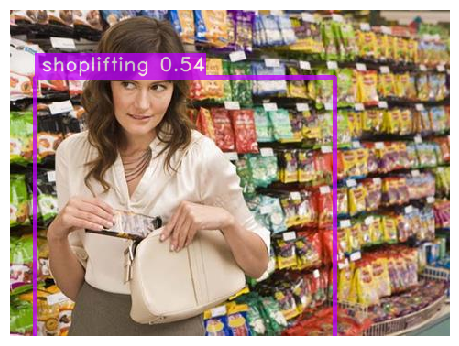

In [51]:
test_image = '/kaggle/input/testing-dataset/testing_dataset/test_image_4.jpg'
model.predict(test_image).show()

In [40]:
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "/kaggle/input/testing-dataset/testing_dataset/test_video_1.mp4"
output_video_path = "/kaggle/working/testing_outputs/detections.mp4"

best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video: 100%|██████████| 616/616 [00:11<00:00, 53.04it/s]
